Combined Data:
0.99 Quantile: 0.0068577777777777
0.999 Quantile: 0.02000724444444468
Skewness: 115.00777896073168
Kurtosis: 14447.519338775826

Control Data:
0.99 Quantile: 0.00681234444444438
0.999 Quantile: 0.020101637777777966
Skewness: 120.11890512657766
Kurtosis: 16149.1679105986

Treatment Data:
0.99 Quantile: 0.0068944444444444
0.999 Quantile: 0.019888429166666884
Skewness: 110.10639274411007
Kurtosis: 13009.257997165754


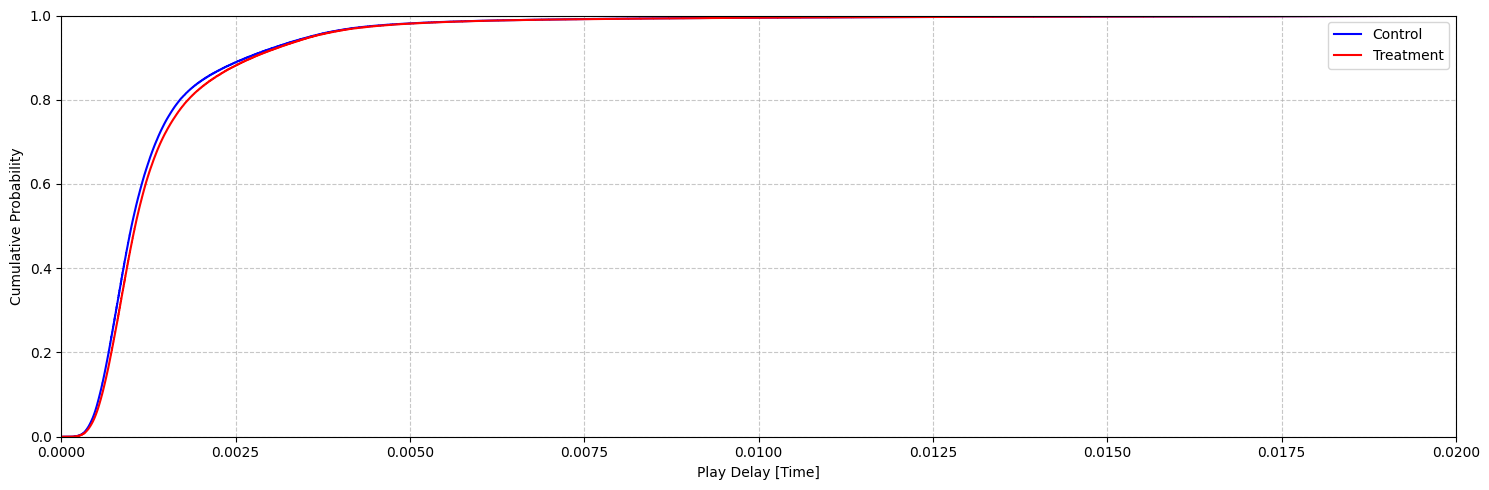

In [2]:
#import pandas as pd
#import numpy as np

#df = pd.read_csv("../mcclearen.csv")
#df['play_delay'] = df['play_delay_ms'] / df['play_delay_ms'].max()
#df['pre_play_delay'] = df['avg_pre_treatment_play_delay_ms'] / df['play_delay_ms'].max()

#df['treatment'] = df['cell']-1
#df['treatment'] = 1 - df['treatment']


#df['log_play_delay'] = np.log(df['play_delay_ms']) / np.max(np.log(df['play_delay_ms']))
#df['log_pre_play_delay'] = np.log(df['avg_pre_treatment_play_delay_ms']) / np.max(np.log(df['play_delay_ms']))

#df = df[['treatment', 'play_delay', 'pre_play_delay', 'log_play_delay', 'log_pre_play_delay']]
#df.to_csv("playdelay.csv", index=False)



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

df = pd.read_csv("playdelay.csv")
data = df['play_delay'].values
print("Combined Data:")
print("0.99 Quantile: {}".format(np.quantile(data, 0.99)))
print("0.999 Quantile: {}".format(np.quantile(data, 0.999)))
print("Skewness: {}".format(sp.stats.skew(data)))
print("Kurtosis: {}".format(sp.stats.kurtosis(data)))
print("")



control_df = df[df['treatment'] == 0]
treatment_df = df[df['treatment'] == 1]


plt.figure(figsize=(15, 5))

# Sample data array
data = control_df['play_delay'].values
x = np.sort(data)
y = np.arange(1, len(x) + 1) / len(x)
plt.step(x, y, where='post',label="Control", color="blue")
print("Control Data:")
print("0.99 Quantile: {}".format(np.quantile(data, 0.99)))
print("0.999 Quantile: {}".format(np.quantile(data, 0.999)))
print("Skewness: {}".format(sp.stats.skew(data)))
print("Kurtosis: {}".format(sp.stats.kurtosis(data)))
print("")

# Sample data array
data = treatment_df['play_delay'].values
x = np.sort(data)
y = np.arange(1, len(x) + 1) / len(x)
plt.step(x, y, where='post',label="Treatment", color="red")
print("Treatment Data:")
print("0.99 Quantile: {}".format(np.quantile(data, 0.99)))
print("0.999 Quantile: {}".format(np.quantile(data, 0.999)))
print("Skewness: {}".format(sp.stats.skew(data)))
print("Kurtosis: {}".format(sp.stats.kurtosis(data)))

plt.ylabel('Cumulative Probability')
#plt.xscale('log')
plt.xlim(0,0.02)
plt.xlabel("Play Delay [Time]")
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig("jasa_play_delay_cdf.png",dpi=300)
plt.show()




In [3]:
import numpy as np
from scipy import stats
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


def generate_data(n, null=True):
    """
    Generate data by sampling from a dataframe with replacement.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns ['treatment', 'pre_play_delay', 'play_delay']
    n (int): Number of samples to generate
    null (bool): Whether to sample under the null hypothesis
    
    Returns:
    W (numpy.ndarray): Design matrix with [intercept, pre_play_delay, treatment]
    y (numpy.ndarray): Outcome variable (play_delay)
    """
    if null:
        
        # Sample n rows with replacement
        sampled_indices = np.random.choice(control_df.index, size=n, replace=True)
        sampled_data = control_df.loc[sampled_indices].copy()
        
        # Randomly assign treatment with probability 0.5
        sampled_data['treatment'] = np.random.binomial(1, 0.5, size=n)
        sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)
        # Extract outcome variable
        y = sampled_data['play_delay'].values
        
        # Create design matrix W = [1, pre_play_delay, treatment]
        W = np.column_stack((
            np.ones(n),                          # Intercept
            sampled_data['pre_play_delay'].values,  # pre_play_delay
            sampled_data['treatment'].values        # treatment
        ))

    else:
        # Simulate number of control observations from binomial(n, 0.5)
        n_control = np.random.binomial(n, 0.5)
        n_treatment = n - n_control
        
        # Sample directly from each group
        control_samples = control_df.sample(n=n_control, replace=True)
        treatment_samples = treatment_df.sample(n=n_treatment, replace=True)
        
        # Combine the samples
        sampled_data = pd.concat([control_samples, treatment_samples]).reset_index(drop=True)
        sampled_data = sampled_data.sample(frac=1).reset_index(drop=True)
                # Extract outcome variable
        y = sampled_data['log_play_delay'].values
        
        # Create design matrix W = [1, pre_play_delay, treatment]
        W = np.column_stack((
            np.ones(n),                          # Intercept
            sampled_data['log_pre_play_delay'].values,  # pre_play_delay
            sampled_data['treatment'].values        # treatment
        ))

    return W, y

# Compute OLS estimates at each step with rank-1 updates
def compute_sequential_estimates(W_all, y_all):
    n_samples = len(y_all)
    n_min = p + d + 2  # Minimum sample size to start with
    
    # Arrays to store results
    delta_hats = np.full(n_samples, np.nan)  # Store as NaN until computable
    s_squared_vals = np.full(n_samples, np.nan)
    
    # Matrix for storing Sigma_delta at each step
    Sigma_deltas = np.full((n_samples, d, d), np.nan)
    
    # Matrix for storing (Z'Z)^-1 at each step for F statistic calculation
    ZtZ_invs = np.full((n_samples, d, d), np.nan)
    
    # Indicator of when estimates become valid
    valid_indices = []
    
    # Precompute all outer products of W_all rows - this is a key optimization
    # This will be a 3D array of shape (n_samples, p+d, p+d)
    W_outer_products = np.zeros((n_samples, W_all.shape[1], W_all.shape[1]))
    for i in range(n_samples):
        W_outer_products[i] = np.outer(W_all[i], W_all[i])
    
    # Find the minimum n where W'W is invertible
    n_init = n_min
    invertible = False
    
    while n_init <= n_samples and not invertible:
        W_init = W_all[:n_init, :]
        WtW = W_init.T @ W_init
        
        # Check if matrix is invertible
        if np.linalg.matrix_rank(WtW) == WtW.shape[0]:
            invertible = True
        else:
            n_init += 1

    W_init = W_all[:n_init, :]
    y_init = y_all[:n_init]
    WtW = W_init.T @ W_init
    Wty = W_init.T @ y_init
    WtW_inv = np.linalg.inv(WtW)
    gamma_hat = WtW_inv @ Wty
    
    # Extract delta_hat
    delta_hat = gamma_hat[p:p+d]
    
    # Compute s^2
    y_hat = W_init @ gamma_hat
    residuals = y_init - y_hat
    RSS = residuals.T @ residuals
    s_squared = RSS / (n_init - p - d)
    
    # Compute Omega_W_n and its inverse
    Omega_W_n = (1/n_init) * WtW
    Omega_W_n_inv = np.linalg.inv(Omega_W_n)
    Omega_W_n_inv_old = Omega_W_n_inv.copy()  # Store for recursive updates
    
    # Using einsum for efficient computation of Sigma_n
    Sigma_n = np.einsum('i,ijk->jk', residuals**2, W_outer_products[:n_init]) / (n_init - p - d)
    
    # Selection matrix
    E = np.zeros((d, p + d))
    E[:, p:p+d] = np.eye(d)
    
    # Compute Sigma_delta_n
    Sigma_delta_n = E @ Omega_W_n_inv @ Sigma_n @ Omega_W_n_inv @ E.T
    
    # Extract (Z'Z)^-1 from WtW_inv for F statistic calculation
    # This is the lower right d×d submatrix of WtW_inv
    ZtZ_inv = WtW_inv[p:p+d, p:p+d]
    
    # Store initial results
    delta_hats[n_init-1] = delta_hat[0]
    s_squared_vals[n_init-1] = s_squared
    Sigma_deltas[n_init-1, :, :] = Sigma_delta_n
    ZtZ_invs[n_init-1, :, :] = ZtZ_inv
    valid_indices.append(n_init-1)
    
    # Now use rank-1 updates for subsequent observations
    for n in range(n_init+1, n_samples+1):
        # Get new observation
        w_new = W_all[n-1, :]
        y_new = y_all[n-1]
        
        # Sherman-Morrison formula for rank-1 update of inverse
        denom = 1 + w_new @ WtW_inv @ w_new

        # Update WtW_inv using Sherman-Morrison with precomputed outer product
        WtW_inv_update = WtW_inv - (WtW_inv @ W_outer_products[n-1] @ WtW_inv) / denom
        WtW_inv = WtW_inv_update
        
        # Update WtW with precomputed outer product
        WtW = WtW + W_outer_products[n-1]
        
        # Update Wty
        Wty = Wty + w_new * y_new
    
        # Compute gamma_hat with updated matrices
        gamma_hat = WtW_inv @ Wty
        
        # Extract delta_hat
        delta_hat = gamma_hat[p:p+d]
        
        # Update RSS (residual sum of squares)
        # We also need to recompute all residuals since gamma_hat changed
        y_hat_all = W_all[:n, :] @ gamma_hat
        residuals_all = y_all[:n] - y_hat_all
        RSS = residuals_all.T @ residuals_all
        
        # Update s^2
        s_squared = RSS / (n - p - d)
        
        # Update Omega_W_n and its inverse using similar rank-1 update
        if n == n_init+1:
            # For first update, initialize Omega_W_n and its inverse
            Omega_W_n_old = (1/(n-1)) * (WtW - W_outer_products[n-1])
            Omega_W_n = (1/n) * WtW
            Omega_W_n_inv = np.linalg.inv(Omega_W_n)
        else:
            # For subsequent updates, use rank-1 update for Omega_W_n_inv
            Omega_W_n_old = Omega_W_n.copy()
            Omega_W_n = ((n-1)/n) * Omega_W_n_old + (1/n) * W_outer_products[n-1]
            
            # Compute rank-1 update for Omega_W_n_inv using Woodbury identity
            scale = (n-1)/n
            
            scaled_inv_old = (1/scale) * Omega_W_n_inv_old
            denom = scale + w_new @ Omega_W_n_inv_old @ w_new / n
            
            if abs(denom) < 1e-10:
                # If near-singular, compute directly
                Omega_W_n_inv = np.linalg.inv(Omega_W_n)
            else:
                adjustment = (scaled_inv_old @ W_outer_products[n-1] @ scaled_inv_old) / (n * denom)
                Omega_W_n_inv = scaled_inv_old - adjustment
        
        # Store the current inverse for next iteration
        Omega_W_n_inv_old = Omega_W_n_inv
        
        # Using einsum for efficient computation of Sigma_n
        Sigma_n = np.einsum('i,ijk->jk', residuals_all**2, W_outer_products[:n]) / (n - p - d)
        
        # Compute Sigma_delta_n
        Sigma_delta_n = E @ Omega_W_n_inv @ Sigma_n @ Omega_W_n_inv @ E.T
        
        # Extract (Z'Z)^-1 from WtW_inv for F statistic calculation
        ZtZ_inv = WtW_inv[p:p+d, p:p+d]
        
        # Store results
        delta_hats[n-1] = delta_hat[0]
        s_squared_vals[n-1] = s_squared
        Sigma_deltas[n-1, :, :] = Sigma_delta_n
        ZtZ_invs[n-1, :, :] = ZtZ_inv
        valid_indices.append(n-1)
    
    return delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices

# Compute F_n, G_n, E_n, and H_n for various g values
def compute_statistics_for_g(delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices, g_value):
    n_samples = len(delta_hats)
    
    # Initialize arrays
    F_ns = np.full(n_samples, np.nan)
    G_ns = np.full(n_samples, np.nan)
    E_ns = np.full(n_samples, np.nan)
    H_ns = np.full(n_samples, np.nan)  # New array for H_n
    
    for idx in valid_indices:
        n = idx + 1  # Convert to 1-based indexing
        delta_hat = delta_hats[idx]
        s_squared = s_squared_vals[idx]
        Sigma_delta = Sigma_deltas[idx]
        ZtZ_inv = ZtZ_invs[idx]
        
        # Compute F_n using the correct formula: F_n = (δ'(Z'Z)δ) / (d * s²)
        if d == 1:
            # For d=1, simplify to scalar operations
            F_n = (delta_hat**2 / float(ZtZ_inv)) / (d * s_squared)
        else:
            # For d>1, use matrix operations
            F_n = (delta_hat.T @ np.linalg.inv(ZtZ_inv) @ delta_hat) / (d * s_squared)
        
        # Degrees of freedom
        nu_n = n - p - d
        
        # Compute G_n with correct F_n
        factor1 = (g_value / (g_value + n)) ** (d / 2)
        factor2 = (1 + (g_value / (g_value + n)) * (d / nu_n) * F_n) / (1 + (d / nu_n) * F_n)
        factor2 = factor2 ** (-(nu_n + d) / 2)
        
        G_n = factor1 * factor2
        
        # Compute quadratic term for E_n and H_n
        try:
            # For d=1, simplify the quadratic term
            if d == 1:
                Sigma_delta_inv = 1/float(Sigma_delta)
                quadratic_term = delta_hat * Sigma_delta_inv * delta_hat
            else:
                Sigma_delta_inv = np.linalg.inv(Sigma_delta)
                quadratic_term = delta_hat.T @ Sigma_delta_inv @ delta_hat
            
            # Compute E_n
            E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
            
            # Compute Q_n and H_n
            Q_n = n * quadratic_term / d
            factor1_H = (g_value / (g_value + n)) ** (d / 2)
            factor2_H = (1 + (g_value / (g_value + n)) * (d / nu_n) * Q_n) / (1 + (d / nu_n) * Q_n)
            factor2_H = factor2_H ** (-(nu_n + d) / 2)
            H_n = factor1_H * factor2_H
            
        except np.linalg.LinAlgError:
            E_n = np.nan
            H_n = np.nan
            
        # Store computed values
        F_ns[idx] = F_n
        G_ns[idx] = G_n
        E_ns[idx] = E_n
        H_ns[idx] = H_n
    
    return F_ns, G_ns, E_ns, H_ns

# Find first crossing times for various thresholds
def find_crossings(G_ns, E_ns, H_ns, alpha):
    threshold = 1 / alpha
    
    # Find first index where G_n > threshold
    G_indices = np.where(G_ns > threshold)[0]
    first_G_crossing = G_indices[0] + 1 if len(G_indices) > 0 else None
    
    # Find first index where E_n > threshold
    E_indices = np.where(E_ns > threshold)[0]
    first_E_crossing = E_indices[0] + 1 if len(E_indices) > 0 else None
    
    # Find first index where H_n > threshold
    H_indices = np.where(H_ns > threshold)[0]
    first_H_crossing = H_indices[0] + 1 if len(H_indices) > 0 else None
    
    return first_E_crossing, first_G_crossing, first_H_crossing

# Run a single simulation
def run_single_simulation(null=True):
    # Generate data once
    W_all, y_all = generate_data(n_total, null=null)
    
    # Compute OLS estimates and variances for all sample sizes
    delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices = compute_sequential_estimates(W_all, y_all)
    
    # For each g value, compute statistics
    results = {}
    for g_value in g_values:
        F_ns, G_ns, E_ns, H_ns = compute_statistics_for_g(delta_hats, s_squared_vals, Sigma_deltas, ZtZ_invs, valid_indices, g_value)
        
        # For each alpha, find crossing times
        crossings = {}
        for alpha in alpha_values:
            first_E_crossing, first_G_crossing, first_H_crossing = find_crossings(G_ns, E_ns, H_ns, alpha)
            crossings[alpha] = (first_E_crossing, first_G_crossing, first_H_crossing)
        
        results[g_value] = {
            'F_ns': F_ns,
            'G_ns': G_ns,
            'E_ns': E_ns,
            'H_ns': H_ns,  # Store H_ns
            'crossings': crossings
        }
    
    return results

# Run multiple simulations
def run_multiple_simulations(null=True):
    all_results = {}
    
    for g_value in g_values:
        all_results[g_value] = {}
        
        for alpha in alpha_values:
            all_results[g_value][alpha] = {
                'E_crossings': [],
                'G_crossings': [],
                'H_crossings': []  # Add H_crossings
            }
    
    print(f"Running {n_simulations} simulations...")
    for sim in tqdm(range(n_simulations)):
        np.random.seed(42 + sim)  # Different seed for each simulation
        
        # Run a single simulation with all g and alpha values
        sim_results = run_single_simulation(null=null)
        
        # Extract and store crossing times
        for g_value in g_values:
            for alpha in alpha_values:
                first_E, first_G, first_H = sim_results[g_value]['crossings'][alpha]
                all_results[g_value][alpha]['E_crossings'].append(first_E)
                all_results[g_value][alpha]['G_crossings'].append(first_G)
                all_results[g_value][alpha]['H_crossings'].append(first_H)
    
    # Compute summary statistics
    for g_value in g_values:
        for alpha in alpha_values:
            # Get crossing data
            E_crossings = all_results[g_value][alpha]['E_crossings']
            G_crossings = all_results[g_value][alpha]['G_crossings']
            H_crossings = all_results[g_value][alpha]['H_crossings']
            
            # Compute probabilities
            prob_E = np.mean([x is not None for x in E_crossings])
            prob_G = np.mean([x is not None for x in G_crossings])
            prob_H = np.mean([x is not None for x in H_crossings])
            
            # Compute average crossing times (when they exist)
            valid_E = [x for x in E_crossings if x is not None]
            valid_G = [x for x in G_crossings if x is not None]
            valid_H = [x for x in H_crossings if x is not None]
            
            avg_E = np.mean(valid_E) if valid_E else None
            avg_G = np.mean(valid_G) if valid_G else None
            avg_H = np.mean(valid_H) if valid_H else None
            
            # Store summary statistics
            all_results[g_value][alpha]['prob_E'] = prob_E
            all_results[g_value][alpha]['prob_G'] = prob_G
            all_results[g_value][alpha]['prob_H'] = prob_H
            all_results[g_value][alpha]['avg_E'] = avg_E
            all_results[g_value][alpha]['avg_G'] = avg_G
            all_results[g_value][alpha]['avg_H'] = avg_H
    
    return all_results


def plot_cumulative_stopping_times(results, alpha=0.05, n_total=1000, n_simulations=1000, ylim_max=1):
    """
    Plot the cumulative proportion of simulations that have stopped by time n.
    
    Parameters:
    -----------
    results : dict
        The nested dictionary returned by the run_multiple_simulations function.
    alpha : float, default=0.05
        The significance level to use for the analysis.
    n_total : int, default=1000
        Total number of observations in each simulation.
    n_simulations : int, default=1000
        Number of simulations run.
    ylim_max : float, default=1
        Maximum y-axis limit for the plot.
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot.
    """
    # Set up the plot
    plt.figure(figsize=(15, 5))
    
    # Define line styles and colors for different g values and statistics
    g_values = list(results.keys())
    line_styles = ['-', '--', ':',]
    colors = ['blue', 'red', 'green']  # Added green for H_n
    
    # Prepare data for plotting
    x = np.arange(1, n_total + 1)
    
    # Plot cumulative stopping times for each g value
    for i, g in enumerate(g_values):
        # Get stopping times for E_n
        if g not in [1,10,1000]:
            continue
        E_crossings = results[g][alpha]['E_crossings']
        
        # Convert None to n_total + 1 (never stopped)
        E_crossings = [n if n is not None else n_total + 1 for n in E_crossings]
        
        # Calculate cumulative proportion that stopped by each time point
        cum_stops_E = np.array([np.mean([stop <= n for stop in E_crossings]) for n in x])
        
        # Plot E_n stopping times
        plt.plot(x, cum_stops_E, 
                 linestyle=line_styles[i % len(line_styles)], 
                 color=colors[0],
                 label=f'$E^G_n, g={g}$')
        
        # Get stopping times for G_n
        G_crossings = results[g][alpha]['G_crossings']
        
        # Convert None to n_total + 1 (never stopped)
        G_crossings = [n if n is not None else n_total + 1 for n in G_crossings]
        
        # Calculate cumulative proportion that stopped by each time point
        cum_stops_G = np.array([np.mean([stop <= n for stop in G_crossings]) for n in x])
        
        # Plot G_n stopping times
        plt.plot(x, cum_stops_G, 
                 linestyle=line_styles[i % len(line_styles)], 
                 color=colors[1],
                 label=f'$G_n, g={g}$')
        
        # Get stopping times for H_n
        H_crossings = results[g][alpha]['H_crossings']
        
        # Convert None to n_total + 1 (never stopped)
        H_crossings = [n if n is not None else n_total + 1 for n in H_crossings]
        
        # Calculate cumulative proportion that stopped by each time point
        cum_stops_H = np.array([np.mean([stop <= n for stop in H_crossings]) for n in x])
        
        # Plot H_n stopping times
        plt.plot(x, cum_stops_H, 
                 linestyle=line_styles[i % len(line_styles)], 
                 color=colors[2],
                 label=f'$E_n, g={g}$')
    
    plt.axhline(y=alpha, linestyle='dashed', color='black', label=f"α = {alpha}")
    
    # Customize the plot
    plt.xlabel('Sample Size (n)', fontsize=12)
    plt.ylabel('Proportion of Nulls Rejected', fontsize=12)
    plt.legend(loc='upper right', framealpha=1, facecolor='white', edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set axis limits
    plt.ylim(0, ylim_max)
    plt.xlim(0, n_total)
    
    plt.tight_layout()
    return plt.gcf()

# AIPW EMPIRICAL BERNSTEIN CODE


In [4]:
from itertools import tee, chain
from fn.iters import take
from copy import deepcopy
import multiprocessing
from joblib import Parallel, delayed
from fn.iters import takewhile

def data_stream(df, adjusted=True, interacted = True):
    for _, row in df.iterrows():
        observation = np.log(row.play_delay)
        treatment = row.treatment
        pre_treatment_observation = np.log(row.pre_play_delay)
        covariates = [treatment, 1]
        if adjusted:
            covariates = covariates + [pre_treatment_observation]
        if interacted:
            covariates = covariates + [treatment * pre_treatment_observation]
        yield {"observation": observation, "covariates": np.array(covariates)}
        
def aa_simulator(df, p, adjusted=True, interacted = True):
    while True:
        row = df.sample(n=1, replace=True)
        observation = row.play_delay.values[0]
        treatment = np.random.binomial(1,p)
        pre_treatment_observation = row.pre_play_delay.values[0]
        covariates = [treatment, 1]
        if adjusted:
            covariates = covariates + [pre_treatment_observation]
        if interacted:
            covariates = covariates + [treatment * pre_treatment_observation]
        yield {"observation": observation, "covariates": np.array(covariates)}
        
def ab_simulator(df_A, df_B, p, adjusted=True, interacted = True):
    while True:
        treatment = np.random.binomial(1, p)
        row = df_B.sample(n=1, replace=True) if treatment == 1 else df_A.sample(n=1, replace=True)
        observation = row.log_play_delay.values[0]
        assert treatment == row.treatment.values[0]
        pre_treatment_observation = row.log_pre_play_delay.values[0]
        covariates = [treatment, 1]
        if adjusted:
            covariates = covariates + [pre_treatment_observation]
        if interacted:
            covariates = covariates + [treatment * pre_treatment_observation]
        yield {"observation": observation, "covariates": np.array(covariates)}



cpu_count = multiprocessing.cpu_count()
print("CPU Count: {}".format(cpu_count))



from itertools import accumulate, chain, tee
from fn.iters import iterate, drop
from copy import deepcopy

import numpy as np
import scipy.special as sp
import scipy.optimize as so

def rank_1_update(Mi, v):
    Miv = Mi.dot(v)
    return Mi - np.outer(Miv, Miv) / (1.0 + v.dot(Miv))

def sufficient_statistic_aggregator(sufficient_statistics, datapoint):
    """
    Fn: sufficient_statistics, datapoints -> sufficient_statistics
    A reduction operator for accumulating sufficient statistics across
    a stream of datapoints
    """
    [n, YY, WY, WW, iWW, estimable] = sufficient_statistics
    observation = datapoint["observation"]
    covariates = datapoint["covariates"]
    n = n + 1
    if n == 1:
        YY = observation**2
        WY = observation * covariates
        WW = np.outer(covariates, covariates)
    else:
        YY = YY + observation**2
        WY = WY + observation * covariates
        WW = WW + np.outer(covariates, covariates)

    if not estimable:
        rank = len(WY)
        if np.linalg.eigvals(WW).min() > 0.00000001 and n > rank:
            estimable = True
            iWW = np.linalg.inv(WW)
        else:
            iWW = None
    else:
        iWW = rank_1_update(iWW, covariates)
    return [n, YY, WY, WW, iWW, estimable]

def sufficient_statistic_transformer(datapoint_generator):
    """
    Fn: generator -> generator
    takes a generator of datapoints and returns a generator of cumulative sufficient
    statistics.
    """
    WW = None
    iWW = None
    WY = None
    YY = None
    n = 0
    estimable = False
    initial_sufficient_statistics = [n, YY, WY, WW, iWW, estimable]
    gen = accumulate(
        datapoint_generator,
        sufficient_statistic_aggregator,
        initial=initial_sufficient_statistics,
    )
    return drop(1, gen)


def regression_coefficients_transformer(sufficient_statistics):
    inv_XX = sufficient_statistics[4]
    XY = sufficient_statistics[2]
    if inv_XX is None:
        return np.zeros(len(XY))
    else:
        return inv_XX.dot(XY)

def project_interval(x, a, b):
    if x < a:
        return a
    elif x > b:
        return b
    else:
        return x

def compute_log_martingale(n, S, V, c, rho, null=0):
    s = np.abs(S - n * null)
    rho_c_sq = rho / (c**2)
    leading_constant = (
        rho_c_sq * np.log(rho_c_sq)
        - sp.gammaln(rho_c_sq)
        - np.log(sp.gammainc(rho_c_sq, rho_c_sq))
    )

    c_sq = c**2
    cs_v_csq = (c * s + V) / c_sq
    v_rho_csq = (V + rho) / c_sq

    return (
        np.log(0.5)
        + leading_constant
        + sp.gammaln(v_rho_csq)
        + np.log(sp.gammainc(v_rho_csq, cs_v_csq + rho / c_sq))
        - v_rho_csq * np.log(cs_v_csq + rho / c_sq)
        + cs_v_csq
    )


def confidence_radius(n, S, V, c, rho, a, b, alpha):
    def root(null_val):
        return compute_log_martingale(n, S, V, c, rho, null=null_val) + np.log(alpha)

    mle = S / n
    if root(b) > 0 and root(mle) < 0:
        radius = so.brentq(root, mle, b)
    elif root(a) > 0 and root(mle) < 0:
        radius = so.brentq(root, a, mle)
    else:
        radius = np.inf
    return radius - mle


def compute_stats(n, S_n, V_n, a, b, rho, null, alpha=0.05, compute_ci=True):
    # Calculate the prefactor

    c = b - a
    log_martingale = compute_log_martingale(n, S_n, V_n, c, rho, null=null)
    mle = S_n / n

    if not compute_ci:
        return {
            "log_martingale": log_martingale,
            "mle": mle,
            "ci_upper": None,
            "ci_lower": None,
            "n": n,
            "S_n": S_n,
            "V_n": V_n,
        }

    radius = confidence_radius(n, S_n, V_n, c, rho, a, b, alpha)
    return {
        "log_martingale": log_martingale,
        "mle": mle,
        "ci_upper": project_interval(mle + radius, a, b),
        "ci_lower": project_interval(mle - radius, a, b),
        "n": n,
        "S_n": S_n,
        "V_n": V_n,
    }


def aipw_prediction(data, a, b, p=0.5):
    outcome, coefficients = data
    covariates = outcome["covariates"]

    # Create a prediction for the control
    control_covariates = deepcopy(covariates)
    control_covariates[0] = 0
    control_covariates[3] = 0
    control_prediction = project_interval(control_covariates.dot(coefficients), a, b)

    # Create a prediction for the treatment
    treatment_covariates = deepcopy(covariates)
    treatment_covariates[0] = 1
    treatment_covariates[3] = treatment_covariates[2]
    treatment_prediction = project_interval(
        treatment_covariates.dot(coefficients), a, b
    )

    return treatment_prediction - control_prediction


def aipw_regression_empirical_bernstein_stream(
    outcome_stream, a, b, rho, p_min, null=0, alpha=0.05, compute_ci=True
):
    observation_stream, prediction_stream, copy_stream = tee(
        outcome_stream, 3
    )
    dim = len(next(copy_stream)["covariates"])
    sufficient_statistics_stream = sufficient_statistic_transformer(prediction_stream)
    regression_coefficients_stream = map(
        regression_coefficients_transformer, sufficient_statistics_stream
    )

    observation_stream_1, observation_stream_2 = tee(observation_stream)
    regression_coefficients_stream_1, regression_coefficients_stream_2 = tee(
        chain([np.zeros(dim)], regression_coefficients_stream)
    )

    aipw_observation_stream = map(
        lambda x: aipw(x, a, b), zip(observation_stream_1, regression_coefficients_stream_1)
    )

    scale = (b - a) / p_min
    aipw_prediction_stream = map(
        lambda x: project_interval(x, -scale, scale),
        map(
            lambda x: aipw_prediction(x, a, b),
            zip(observation_stream_2, regression_coefficients_stream_2),
        ),
    )

    return empirical_bernstein_stream(
        aipw_observation_stream,
        aipw_prediction_stream,
        -scale,
        scale,
        rho,
        null,
        alpha=alpha,
        compute_ci=compute_ci,
    )


def validate(x, a, b, mesg):
    if a <= x <= b:
        return x
    else:
        raise ValueError(mesg + "x={} must be in the interval [{}, {}]".format(x, a, b))


def empirical_bernstein_stream(
    observation_stream, prediction_stream, a, b, rho, null, alpha=0.05, compute_ci=True
):
    validated_observation_stream = map(
        lambda x: validate(x, a, b, "Observation "), observation_stream
    )
    validated_observation_stream_1, validated_observation_stream_2 = tee(
        validated_observation_stream
    )
    validated_prediction_stream = map(
        lambda x: validate(x, a, b, "Prediction "), prediction_stream
    )
    S_n = accumulate(validated_observation_stream_1)
    squared_residual_stream = map(
        lambda x: (x[0] - x[1]) ** 2,
        zip(validated_observation_stream_2, validated_prediction_stream),
    )
    V_n = accumulate(squared_residual_stream)
    sample_size = iterate(lambda x: x + 1, 1)
    return map(
        lambda x: compute_stats(
            x[0], x[1], x[2], a, b, rho, null, alpha=alpha, compute_ci=compute_ci
        ),
        zip(sample_size, S_n, V_n),
    )

def aipw(data, a, b, p=0.5):
    outcome, coefficients = data
    observation = outcome["observation"]

    if not (a <= observation <= b):
        raise ValueError(f"{observation} is outside of the interval [{a}, {b}]")

    covariates = outcome["covariates"]
    propensity = outcome.get("propensity", p)
    treatment = covariates[0]
    prediction = project_interval(covariates.dot(coefficients), a, b)

    # Create a prediction for the control
    control_covariates = deepcopy(covariates)
    control_covariates[0] = 0
    control_covariates[3] = 0
    control_prediction = project_interval(control_covariates.dot(coefficients), a, b)

    # Create a prediction for the treatment
    treatment_covariates = deepcopy(covariates)
    treatment_covariates[0] = 1
    treatment_covariates[3] = treatment_covariates[2]
    treatment_prediction = project_interval(
        treatment_covariates.dot(coefficients), a, b
    )

    out = (treatment_prediction - control_prediction) + (
        (treatment - propensity) / (propensity * (1 - propensity))
    ) * (observation - prediction)

    if -(b - a) / p <= out <= (b - a) / p:
        return out
    else:
        raise ValueError(f"{out} is outside of the interval {-(b - a) / p}, {(b - a) / p}")



CPU Count: 96


# Null Simulation

In [20]:
# Parameters
n_total = 30000  # Total number of observations
p = 2  # Number of x covariates (including intercept)
d = 1  # Dimension of z
n_simulations = 1000  # Number of simulations to run

# Alpha and g parameter grids
alpha_values = [0.05]
g_values = [1, 10, 1000]

In [21]:
import warnings
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)

results_null = run_multiple_simulations()

Running 1000 simulations...


  8%|▊         | 78/1000 [06:55<1:21:18,  5.29s/it]/tmp/ipykernel_2780675/1101538868.py:270: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
 12%|█▏        | 124/1000 [11:00<1:17:38,  5.32s/it]/tmp/ipykernel_2780675/1101538868.py:270: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
 27%|██▋       | 271/1000 [24:01<1:04:22,  5.30s/it]/tmp/ipykernel_2780675/1101538868.py:270: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
 51%|█████     | 507/1000 [44:59<44:16,  5.39s/it]  /tmp/ipykernel_2780675/1101538868.py:270: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
 68%|██████▊   | 676/1000 [1:00:05<30:14,  5.60s/it]/tmp/ipykernel_2780675/1101538868.py:270: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * n

In [22]:
import pickle

# Save results to a file
with open('play_delay_lm_results_null.pkl', 'wb') as f:
    pickle.dump(results_null, f)

In [23]:
p_min = 0.5
b = 1
a=0
rho = 100

def simulation(i):
    p=0.5
    maxn = 30000

    np.random.seed(i)
    obs = take(maxn, aa_simulator(control_df, p, adjusted=True, interacted=True))
    out3 = list(takewhile(lambda x: x['log_martingale'] < -np.log(0.05), aipw_regression_empirical_bernstein_stream(obs, a, b, rho, p_min, null=0, alpha=0.05, compute_ci=False)))

    return len(out3)+1
    
simulation(0)

30001

In [24]:
eb_stopping_times = Parallel(n_jobs=50)(delayed(simulation)(i) for i in range(n_simulations))

print(np.mean(eb_stopping_times))

import pickle

filepath = 'bernstein_playdelay_null.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(eb_stopping_times, f)

30001.0


In [25]:
filepath = 'play_delay_lm_results_null.pkl'
with open(filepath, 'rb') as f:
    results_null = pickle.load(f)

filepath = 'bernstein_playdelay_null.pkl'
with open(filepath, 'rb') as f:
    eb_stopping_times = pickle.load(f)


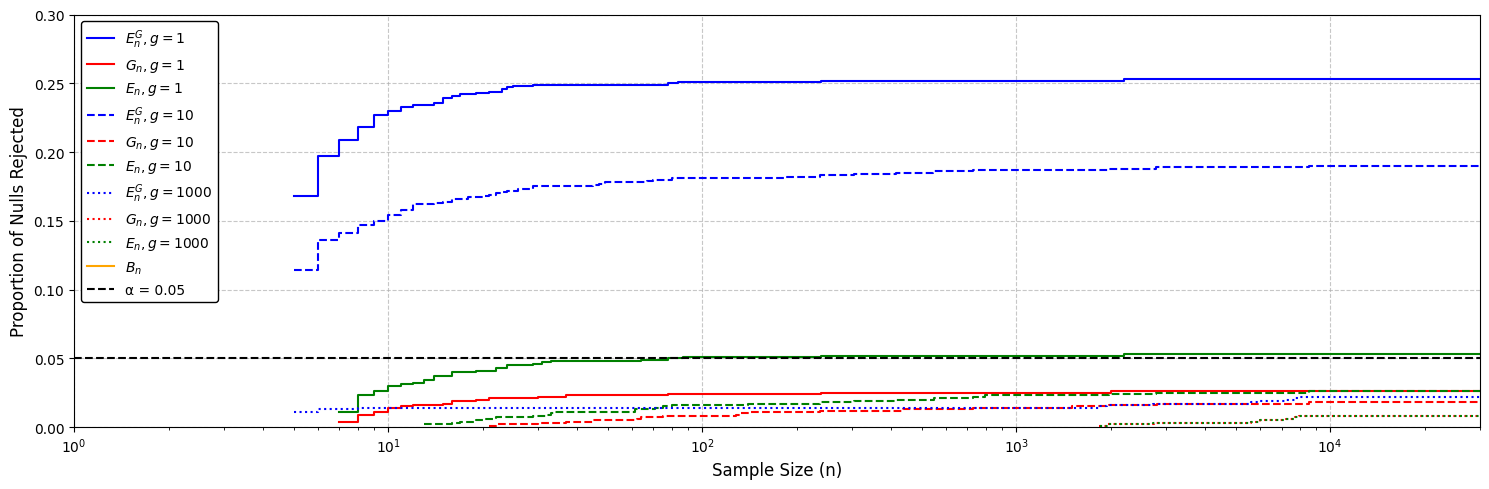

In [26]:
eb_changepoints, eb_counts = np.unique(eb_stopping_times, return_counts=True)
eb_steps = eb_counts / len(eb_stopping_times)

plt.figure(figsize=(15, 5))
alpha = 0.05
line_styles = ['-', '--',  ':',]

for i,g in enumerate([1,10,1000]):
    G_crossings = results_null[g][alpha]['G_crossings']
    G_crossings = [100000 if x is None else x for x in G_crossings]
    G_changepoints, G_counts = np.unique(G_crossings, return_counts=True)
    G_steps = G_counts / len(G_crossings)
    
    E_crossings = results_null[g][alpha]['E_crossings']
    E_crossings = [100000 if x is None else x for x in E_crossings]
    E_changepoints, E_counts = np.unique(E_crossings, return_counts=True)
    E_steps = E_counts / len(E_crossings)
    
    H_crossings = results_null[g][alpha]['H_crossings']
    H_crossings = [100000 if x is None else x for x in H_crossings]
    H_changepoints, H_counts = np.unique(H_crossings, return_counts=True)
    H_steps = H_counts / len(H_crossings)
    plt.step(E_changepoints, np.cumsum(E_steps), where='post', label=f'$E^G_n, g={g}$', color='blue',linestyle=line_styles[i % len(line_styles)])
    plt.step(G_changepoints, np.cumsum(G_steps), where='post', label=f'$G_n, g={g}$', color='red',linestyle=line_styles[i % len(line_styles)])
    plt.step(H_changepoints, np.cumsum(H_steps), where='post', label=f'$E_n, g={g}$', color='green',linestyle=line_styles[i % len(line_styles)])
plt.step(eb_changepoints, np.cumsum(eb_steps), where='post', label="$B_n$", color='orange')
plt.axhline(y=alpha, linestyle='dashed', color='black', label=f"α = {alpha}")
# Customize the plot
plt.xlabel('Sample Size (n)', fontsize=12)
plt.ylabel('Proportion of Nulls Rejected', fontsize=12)
plt.legend(loc='upper left', framealpha=1, facecolor='white', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits
plt.ylim(0, 0.3)

plt.xscale('log')
plt.xlim(1,30000)
plt.tight_layout()
plt.savefig('playdelay_null.png', dpi=300)

In [27]:
# Alternative Simulation

In [28]:
results_alt = run_multiple_simulations(null=False)

Running 1000 simulations...


  0%|          | 0/1000 [00:00<?, ?it/s]

  8%|▊         | 83/1000 [07:59<1:29:27,  5.85s/it]/tmp/ipykernel_2780675/1101538868.py:270: RuntimeWarning: overflow encountered in exp
  E_n = factor1 * np.exp(0.5 * (n / (g_value + n)) * n * quadratic_term)
100%|██████████| 1000/1000 [1:31:29<00:00,  5.49s/it]


In [29]:
import pickle

# Save results to a file
with open('play_delay_lm_results_alt.pkl', 'wb') as f:
    pickle.dump(results_alt, f)

In [30]:
def simulation(i):
    p=0.5
    maxn = 30000

    np.random.seed(i)
    obs = take(maxn, ab_simulator(control_df, treatment_df, p, adjusted=True, interacted=True))
    out3 = list(takewhile(lambda x: x['log_martingale'] < -np.log(0.05), aipw_regression_empirical_bernstein_stream(obs, a, b, rho, p_min, null=0, alpha=0.05, compute_ci=False)))

    return len(out3)+1

eb_stopping_times = Parallel(n_jobs=50)(delayed(simulation)(i) for i in range(n_simulations))

print(np.mean(eb_stopping_times))

import pickle

filepath = 'bernstein_playdelay_alt.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(eb_stopping_times, f)

12654.337


In [31]:
filepath = 'play_delay_lm_results_alt.pkl'
with open(filepath, 'rb') as f:
    results_alt = pickle.load(f)

filepath = 'bernstein_playdelay_alt.pkl'
with open(filepath, 'rb') as f:
    eb_stopping_times = pickle.load(f)


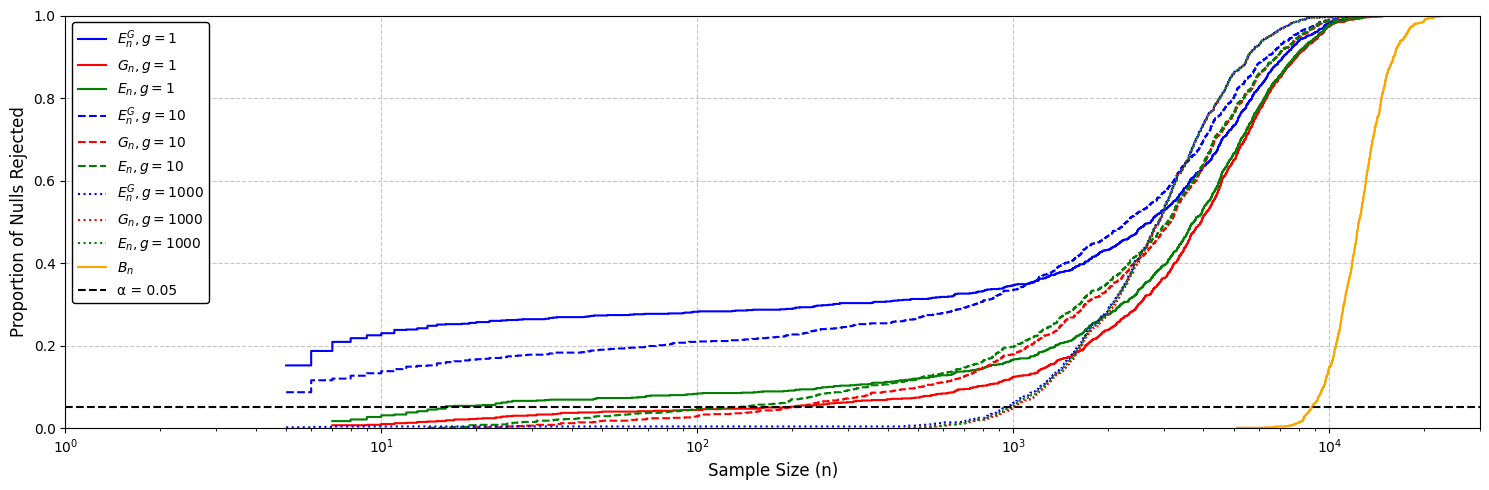

In [32]:
plt.figure(figsize=(15, 5))
alpha = 0.05
line_styles = ['-', '--',  ':',]

eb_changepoints, eb_counts = np.unique(eb_stopping_times, return_counts=True)
eb_steps = eb_counts / len(eb_stopping_times)
len(eb_stopping_times)

for i,g in enumerate([1,10,1000]):
    G_crossings = results_alt[g][alpha]['G_crossings']
    G_crossings = [100000 if x is None else x for x in G_crossings]
    G_changepoints, G_counts = np.unique(G_crossings, return_counts=True)
    G_steps = G_counts / len(G_crossings)
    
    E_crossings = results_alt[g][alpha]['E_crossings']
    E_crossings = [100000 if x is None else x for x in E_crossings]
    E_changepoints, E_counts = np.unique(E_crossings, return_counts=True)
    E_steps = E_counts / len(E_crossings)
    
    H_crossings = results_alt[g][alpha]['H_crossings']
    H_crossings = [100000 if x is None else x for x in H_crossings]
    H_changepoints, H_counts = np.unique(H_crossings, return_counts=True)
    H_steps = H_counts / len(H_crossings)
    plt.step(E_changepoints, np.cumsum(E_steps), where='post', label=f'$E^G_n, g={g}$', color='blue',linestyle=line_styles[i % len(line_styles)])
    plt.step(G_changepoints, np.cumsum(G_steps), where='post', label=f'$G_n, g={g}$', color='red',linestyle=line_styles[i % len(line_styles)])
    plt.step(H_changepoints, np.cumsum(H_steps), where='post', label=f'$E_n, g={g}$', color='green',linestyle=line_styles[i % len(line_styles)])
plt.step(eb_changepoints, np.cumsum(eb_steps), where='post', label="$B_n$", color='orange')
plt.axhline(y=alpha, linestyle='dashed', color='black', label=f"α = {alpha}")
# Customize the plot
plt.xlabel('Sample Size (n)', fontsize=12)
plt.ylabel('Proportion of Nulls Rejected', fontsize=12)
plt.legend(loc='upper left', framealpha=1, facecolor='white', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits
plt.ylim(0, 1)
#plt.xlim(0, 25000)

plt.xscale('log')
plt.xlim(1,30000)
plt.tight_layout()
plt.savefig('playdelay_alt.png', dpi=300)
